# The notebook contains answers to all questions and requirements in project guideline (python scripts, outputs (including plots & tables))

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import plotly
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tashf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tashf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 300)


In [3]:
df=pd.read_csv('Train_rev1.csv')

In [4]:
#drop rows with missing values (assuming missing information in other columns could mean job description is not complete as well) 
df.dropna(inplace=True)

In [5]:
#Assign percentile ranks using SalaryNormalized
df['SalaryNormalized'] = df['SalaryNormalized'].astype(float)
df['Percentile'] =df['SalaryNormalized'].rank(pct=True)
#above 75% is high, below 75% is low
df.loc[df['Percentile'] >= 0.75, 'Target'] = 'high'
df.loc[df['Percentile'] < 0.75, 'Target'] = 'low'
df.head(1)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Percentile,Target
2020,51860115,Financial Accountant,A leading Insurance/Reinsurance Business is currently seeking a high calibre Financial Accountant to take financial and management responsibility for a number of business critical areas. This role will enable the candidate to work within a close team whilst benefiting from the opportunities asso...,London,London,full_time,permanent,CMC Consulting Limited,Accounting & Finance Jobs,"40,000 - 50,000 + Bonus + B",45000.0,myjobs.cimaglobal.com,0.77746,high


In [6]:
#randomly select 2500 rows with  equal number of high and low salary
df_high = df[df['Target'] == 'high'].sample(n=1250, random_state=1)
df_low = df[df['Target'] == 'low'].sample(n=1250, random_state=1)
df = pd.concat([df_high, df_low])
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.head(1)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Percentile,Target
0,70472014,Digital Sales Manager,An award winning advertising technology business specialising in Video and Mobile with an amazing and fun environment is looking for a Digital Sales Manager to join its sales team and continue its impressive expansion. You will need to have impressive online media sales experience and a strong c...,Central London,Central London,full_time,permanent,DIGITAL GURUS,Sales Jobs,35000 - 40000 per annum + 20k uncapped ote,37500.0,jobs.guardian.co.uk,0.65019,low


In [7]:
df.shape

(2500, 14)

In [8]:
df['Target'].value_counts()

low     1250
high    1250
Name: Target, dtype: int64

## 1.Build a classification model with text (full job description) as the predictor. What is the accuracy ofyour model? Show the confusion matrix. Also show the top 10 words (excluding stopwords) that aremost indicative of (i) high salary, and (ii) low salary.

**Note:** To show top words 2 appraoches are used - i recommend approach 2 results as: Approach 2 is better as it specifically identifies unique words associated with high and low salary jobs, offering clearer insights into what differentiates these roles


In [9]:
# Function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def preprocess_text(text):
    # Convert to string
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove html tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-ascii and words containing numbers
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove whitespace
    text = text.strip()
    # Remove urls
    text = re.sub(r'http\S+', '', text)
    # Remove email addresses
    text = re.sub('\S+@\S+', '', text)
    #remove web address
    text = re.sub(r'www\S+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [i for i in tokens if not i in stop_words]
    # Part of Speech Tagging
    nltk_tagged = pos_tag(tokens)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    # Rejoin words
    text = ' '.join(lemmatized_sentence)
    return text

# Applying the preprocessing function to the FullDescription column
df['cleaned_text'] = df['FullDescription'].apply(preprocess_text)

In [10]:
# Apply preprocessing function to the full description
df['cleaned_text'] = df['FullDescription'].apply(preprocess_text)

In [11]:
df.head(1)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Percentile,Target,cleaned_text
0,70472014,Digital Sales Manager,An award winning advertising technology business specialising in Video and Mobile with an amazing and fun environment is looking for a Digital Sales Manager to join its sales team and continue its impressive expansion. You will need to have impressive online media sales experience and a strong c...,Central London,Central London,full_time,permanent,DIGITAL GURUS,Sales Jobs,35000 - 40000 per annum + 20k uncapped ote,37500.0,jobs.guardian.co.uk,0.65019,low,award win advertise technology business specialise video mobile amaze fun environment look digital sale manager join sale team continue impressive expansion need impressive online medium sale experience strong contact book across uk market company deal premium uk publisher well serve bluechip br...


In [12]:
#keep only the cleaned_text and Target columns
df = df[['cleaned_text', 'Target']].copy()

#mapping target variable High to 1 and Low to 0
df['Target'] = df['Target'].map({'high': 1, 'low': 0})

In [13]:
#use TfidfVectorizer to convert the text into a matrix of TF-IDF features
vectorizer = TfidfVectorizer() #sublinear_tf=True
#This addresses the issue that “twenty occurrences of a term in a document” does not represent “twenty times the significance of a single occurrence
#for simplicity, I will not use sublinear_tf=True
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['Target']
#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
#parameter grid
param_grid = {
    'alpha': (1,1e-2, 1e-3)
}

#naive bayes classifier
nb = MultinomialNB()
#grid search
gs = GridSearchCV(nb, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (1, 0.01, 0.001)}, scoring='accuracy',
             verbose=1)

In [15]:
#best parameters
print('Best parameters:', gs.best_params_)

Best parameters: {'alpha': 0.01}


In [16]:
#best score
print('Best score:', gs.best_score_)

Best score: 0.7605000000000001


In [17]:
#train the model with the best parameters
nb = MultinomialNB(alpha=gs.best_params_['alpha'])
nb.fit(X_train, y_train)
#predict the target
y_pred = nb.predict(X_test)
#classification report
print(classification_report(y_test, y_pred))
#confusion matrix
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

        high       0.71      0.80      0.75       238
         low       0.79      0.71      0.75       262

    accuracy                           0.75       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500

[[190  48]
 [ 77 185]]


In [25]:
#save the model
import joblib
joblib.dump(nb, 'model.pkl')   
#save the vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')


['vectorizer.pkl']

In [18]:
#Accuracy
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.75


C:\Users\tashf\AppData\Local\Temp\ipykernel_24904\457886792.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Low', 'High'])
C:\Users\tashf\AppData\Local\Temp\ipykernel_24904\457886792.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Low', 'High'])


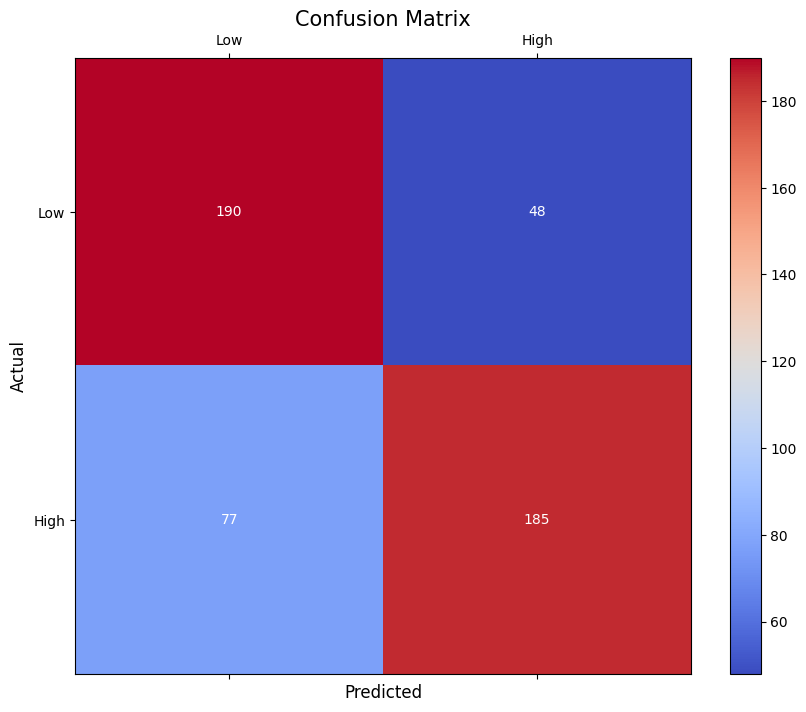

In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))  
cax = ax.matshow(conf_matrix, cmap='coolwarm')  

plt.colorbar(cax)

for (i, j), value in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black' if conf_matrix.min() > 50 else "white")

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

ax.set_xticklabels([''] + ['Low', 'High'])
ax.set_yticklabels([''] + ['Low', 'High'])

plt.title('Confusion Matrix', fontsize=15)

plt.show()

### Approach 1: Direct Probability Comparison - to show top words in high and low salary

In [20]:
class_prob = nb.class_log_prior_
class_labels = nb.classes_

print('Prior Class probabilities:')
for label, prob in zip(class_labels, np.exp(class_prob)):
    print(f"{label}: {prob}")

# Considering target class had equal distribution, prior class probabilities should be 0.5 for each class

Prior Class probabilities:
high: 0.5060000000000002
low: 0.49400000000000027


In [21]:
feature_prob_class_0 = np.exp(nb.feature_log_prob_[0])

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for class 0
df_class_0 = pd.DataFrame({'Feature': feature_names, 'Probability': feature_prob_class_0})

# Sort the DataFrame by probability in descending order
df_class_0_sorted = df_class_0.sort_values('Probability', ascending=False).reset_index(drop=True)

print("Top High Salary words:")
df_class_0_sorted.head(10)

Top High Salary words:


,Feature,Probability
0,business,0.005448
1,experience,0.005003
2,work,0.004550
3,project,0.003948
4,client,0.003892
5,team,0.003889
6,role,0.003858
7,management,0.003782
8,manager,0.003357
9,financial,0.003321


**High Salary Words:**

The words "business", "experience", "work", "project", "client", "team", "role", "management", "manager", and "financial" prominently feature in high salary jobs.

**Professional and Leadership Focus:** This set underscores a strong emphasis on professional experience, business acumen, and project management. Words like "management", "manager", "financial", and "lead" suggest roles that require leadership qualities, financial expertise, and the ability to oversee and drive projects.

**Team and Client Orientation:** The recurrence of "team", "client", and "role" highlights the importance of collaboration, client relations, and clear role definitions within organizations, indicating positions that likely involve coordination among various stakeholders

In [22]:
feature_prob_class_1 = np.exp(nb.feature_log_prob_[1])

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for class 1
df_class_1 = pd.DataFrame({'Feature': feature_names, 'Probability': feature_prob_class_1})

# Sort the DataFrame by probability in descending order
df_class_1_sorted = df_class_1.sort_values('Probability', ascending=False).reset_index(drop=True)

# Display the DataFrame
print("Top Low Salary words:")
df_class_1_sorted.head(10)

Top Low Salary words:


,Feature,Probability
0,work,0.004902
1,sale,0.004461
2,experience,0.004089
3,client,0.003633
4,school,0.003471
5,role,0.003390
6,service,0.003343
7,team,0.003282
8,teacher,0.003162
9,business,0.003076


**Low Salary Words:**

For low salary jobs, the top words are "work", "sale", "experience", "client", "school", "role", "service", "team", "teacher", and "business".

**Operational and Educational Focus:** The presence of "sale", "service", "school", and "teacher" points towards roles with a strong operational or educational component. These might include sales positions, customer service roles, or educational roles that do not require as much specialized knowledge or leadership experience as those in the high salary bracket.

**Customer and Support Emphasis:** Words like "customer", "support", and "service" indicate jobs focused on providing support and services, which are crucial for maintaining business operations but might not offer the same level of compensation as more specialized roles

**Concluding Insights:**

**High Salary Insights:**
The high salary class is marked by terms like "business", "experience", "work", "project", "client", "team", "role", "management", "manager", and "financial". These words collectively paint a picture of roles steeped in complexity and specialization, with a clear emphasis on leadership qualities and strategic business or technical acumen

**Low Salary Insights:**

Conversely, the low salary class features words like "work", "sale", "experience", "client", "school", "role", "service", "team", "teacher", and "business". This vocabulary skews more towards operational and customer-facing duties, with "sale", "service", and "client" highlighting the service-oriented nature of these roles. The inclusion of "school" and "teacher" points to a significant representation of educational roles, which, while essential, may not offer the financial rewards associated with more specialized or leadership-driven positions

### Approach 2 to show top words in high and low salary

In Approach 2, I refined the analysis to identify words uniquely associated with high and low salary jobs by comparing the top words from each class and pinpointing those exclusive to each list, we gain further insights into the distinguishing characteristics of these roles

In [23]:
different_words= set(list(df_class_0_sorted.head(30)['Feature'])) - set(list(df_class_1_sorted.head(30)['Feature']))
different_words
different_words_list = list(different_words)
different_words_df = df_class_0_sorted[df_class_0_sorted['Feature'].isin(different_words_list)].reset_index(drop=True)

print("Top words that only exist in high salary, ordered by feature importance:")
different_words_df.head(15)

Top words that only exist in high salary, ordered by feature importance:


,Feature,Probability
0,project,0.003948
1,financial,0.003321
2,finance,0.002902
3,lead,0.002792
4,strong,0.002609
5,manage,0.002567
6,design,0.002511
7,commercial,0.002340
8,ensure,0.002335
9,senior,0.002331


**High Salary Unique Words:**

Words uniquely associated with high salaries include "commercial", "design", "develop", "ensure", "finance", "financial", "lead", "manage", "project", "senior", "strong", and "system".

**Specialization and Strategy:** These words reflect a high degree of specialization ("finance", "financial", "system") and strategic roles ("lead", "manage", "senior"). The emphasis on "design", "develop", and "project" suggests innovation and creation, key in roles that command higher salaries.

In [24]:
different_words1= set(list(df_class_1_sorted.head(30)['Feature']))-set(list(df_class_0_sorted.head(30)['Feature'])) 
different_words1
different_words_list1 = list(different_words1)
different_words_df1 = df_class_1_sorted[df_class_1_sorted['Feature'].isin(different_words_list1)].reset_index(drop=True)
print("Top words that only exist in low salary, ordered by feature importance:")
different_words_df1.head(12)

Top words that only exist in low salary, ordered by feature importance:


,Feature,Probability
0,school,0.003471
1,teacher,0.003162
2,customer,0.002847
3,company,0.002835
4,support,0.002786
5,look,0.002626
6,require,0.002310
7,excellent,0.002285
8,recruitment,0.002261
9,must,0.002183


**Low Salary Unique Words:**

Unique to low salary jobs are "company", "customer", "excellent", "look" (probably stopword), "must","recruitment", "require", "school", "support", "teacher", "provide", "Year"

**Support and Service:** This list leans towards support ("support", "customer", "service") and foundational roles within a company or educational settings ("school", "teacher"). These terms may represent positions essential for daily operations and customer engagement but are typically entry-level or require less specialized expertise.

**Concluding Insights:**

**High Salary Unique Words:**
Unique words associated with high salary jobs include "commercial", "design", "develop", "ensure", "finance", "financial", "lead", "manage", "project", "senior", "strong", and "system". These terms suggest a significant emphasis on roles that demand not only technical and design expertise but also a strong grasp of commercial and financial strategies. Words like "lead", "manage", and "senior" underscore leadership roles, indicating positions of authority and responsibility that likely involve guiding teams or projects towards success. "Develop", "design", and "system" reflect the innovation and technical skill required in these roles, highlighting a need for individuals capable of creating or improving systems, products, or processes. The presence of "financial" and "finance" points towards roles where financial oversight, investment acumen, or economic analysis plays a critical part

**Low Salary Unique Words:**

For low salary jobs, unique words include "company", "customer", "excellent", "look", "must", "provide", "recruitment", "require", "school", "support", "teacher", and "year". This set leans heavily towards roles centered around support, customer service, and education. "Customer", "support", and "service" suggest positions focused on direct interaction with customers or clients, providing assistance and ensuring satisfaction. The inclusion of "school", "teacher", and "recruitment" highlights the educational and human resources sectors, indicating roles essential for organizational support and educational development but perhaps not as highly compensated as those requiring specialized technical or leadership skills. 

## 2. If you wanted to increase the accuracy of the model above, how can you accomplish this using thedataset you have?

**N-gram Analysis**: Expanding our analysis to include bigrams and trigrams could capture context and phraseology better than single words (unigrams). This could reveal patterns like "senior engineer" or "entry level" that are more directly correlated with salary levels

**Incorporate Log Probabilities**: Leveraging log probabilities helps address the issue of numerical underflow that can happen when multiplying many small probabilities together, a common issue in Naive Bayes models.

**Leverage Job Metadata**: Features like Job Title, Location, Contract Type, and Category are likely to have predictive value. For instance, jobs in certain locations or within specific sectors might consistently offer higher salaries. Adding these as features, either as categorical variables or through additional text processing, could significantly improve model accuracy.

**Incorporate Sentiment Analysis**: The sentiment or tone of a job description could correlate with salary levels. Positive, confident language could indicate higher-paying roles. Incorporating sentiment analysis results as a feature could provide another dimension to the model

**Synonyms and Feature Correlation**: Naive Bayes assumes feature independence, an assumption often violated in text data due to synonyms and correlated terms. Identifying and merging synonyms or using dimensionality reduction techniques could mitigate the double-counting effect of correlated features, making the model's probability estimates more reliable

**Hyperparameter Tuning**: Beyond alpha in Naive Bayes, exploring hyperparameters in vectorization methods (such as the max_features, min_df, and ngram_range in TfidfVectorizer) through grid search or random search can fine-tune our model's performance.

**Ensemble Methods**: Combining the Naive Bayes model with other classifiers through ensemble techniques like stacking, voting, or boosting could leverage the strengths of multiple models, potentially leading to improved accuracy

# End 